<div style="float:left"><h1>  Your Personalized Food Travel Guide: Yelp Recommender System</h1></div>


**Author:** Alex Xue 

**Contact:** alex.xue15@gmail.com

**Date:** December 12th

## Table Of Contents 
1. [Introduction to this Notebook](#Introduction-to-this-Notebook)
2. [Pre-Modeling](#Pre-Modeling)
3. [Content-Based Recommendation](#Content-Based-Recommendations)
4. [Conclusion to this Notebook](#Conclusion-to-this-Notebook)

## Introduction to this Notebook

In this notebook, we'll be using the dataframe that we just finished with in the previous notebook. As well, we'll be going over PCA and Scaling of our numeric data. Additionally we'll be building a content-based recommender system using KNN as our model, and cosine similarity as our measure of distance between businesses. Then we'll be developing methods to evaluate our model's performance. Lastly, we'll briefly discuss the cold-start problem. 

In [1]:
import numpy as np #importing numpy 
import pandas as pd #importing pandas 
import matplotlib.pyplot as plt #importing matplotlib
import re #importing regex
import seaborn as sns #importing seaborn

### Final Business Dataframe

In [2]:
#Reading in the Business dataframe 
df_business_final=pd.read_csv('data/df_final.csv',index_col=0)

In [3]:
#Reading in the review dataframe 
df_reviews=pd.read_csv("data/Yelp_dataset_old/yelp_review.csv")

We'll need both the reviews dataframe and the finalized business dataframe. Similar to the previous notebook, we'll be combining the dataframes and creating what were going to call `df_reviews_merged` which will be all the reviews attached to their respective businesses, joined on business_id.

In [4]:
#Renaming the columns to not get confused
df_reviews=df_reviews.rename(columns={'stars':'Review_star'})

In [5]:
#Creating the merged dataframe
df_reviews_merged=pd.merge(df_business_final,df_reviews,on='business_id',how='left')

After we've created our df_review_merged, we'll be resetting the index and dropping the created column. This is because a lot of the functions that we'll be using are made in a way that there needs to be a continuous index. If we ever need the original index back, we can join it to our original csv based on business ID and get it from there.

In [6]:
#resetting the index
df_business_final=df_business_final.reset_index()

In [7]:
#dropping 3 of our columns
df_final=df_business_final.drop(columns=['business_id','name','copy_index'])

Now we need to create a numeric column for State as we'll be putting it through PCA and all columns need to be numeric for PCA. We'll do this by creating a GTA column, where rows with a state value of ON will be 1 and otherwise will be 0.

In [8]:
#Using Np Where to create a binary column from state
df_final['GTA']=np.where(df_final['state']=='ON',1,0)

In [9]:
#looking at the value count
df_final['GTA'].value_counts()

1    16813
0     9693
Name: GTA, dtype: int64

Looking at the value count, we can confirm the same number of Ontario and Vegas restaurants. We can now safely drop the State column.

In [10]:
#dropping the state column
df_final.drop(columns=['state'],inplace=True)

## Pre-Modeling 

In this section we'll be transforming our data to get it ready to be put into a KNN model. To start, we'll be selecting a scalar. 

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler #importing scalers 
from sklearn.decomposition import PCA #importing PCA

We'll be using a MinMaxScaler, as we can't confirm the normality of the data. As a result, a MinMaxScaler is the choice. Testing with different scalars to see if they impact the recommendation will be done as a next step. 

In [12]:
#Scale data
scaler = MinMaxScaler()
#fitting the scaler to the numeric dataframe
scaler.fit(df_final)
#transform the data
X_train = scaler.transform(df_final)

After we scale our data, we'll be putting into a PCA to see if we can reduce the number of features. 

In [13]:
#Instatitating and fitting the PCA on the scaled data
my_pca=PCA()
my_pca.fit(X_train)

PCA()

In [14]:
#Getting the explained varience by the PCA variables 
expl_var = my_pca.explained_variance_ratio_

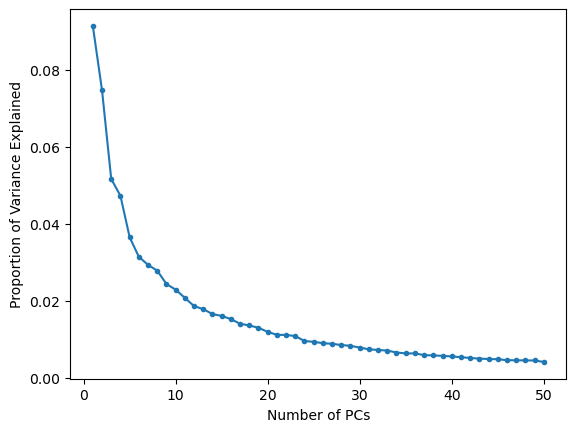

In [15]:
#Plotting the PCA explained varience curve 
plt.figure()
plt.plot(range(1,51),expl_var[0:50],marker='.') #plotting the explained varience 
plt.xlabel('Number of PCs')
plt.ylabel('Proportion of Variance Explained')
plt.show()

We can see that looking at the variance curve, that after around the 6 or 7th Principal component, we see a drop in the variance explained. However, only 6 or 7 would dramatically reduce our variance. We should look at a cumulative sum graph instead to try to see if we can find a good number.

In [16]:
# Calculate the cumulative sum of this array using the 
cumulative_sum = np.cumsum(expl_var)
#Showing the cumulative sums 
cumulative_sum[0:5]

array([0.09133596, 0.16597504, 0.21760626, 0.26489389, 0.30143301])

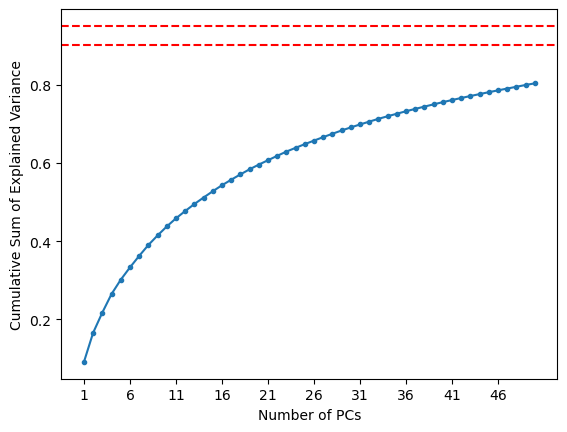

In [17]:
# Plot out the cumulative sum graph
plt.figure()
#plotting the cumlative sums 
plt.plot(range(1,51), cumulative_sum[0:50], marker='.') #plotting cumlative sums from 1-51
plt.axhline(0.95, c='r', linestyle='--') #creating horizontal lines in red 
plt.axhline(0.90, c='r', linestyle='--') #creating horizontal lines in red 
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Sum of Explained Variance')
plt.xticks(range(1,51,5))
plt.show()

Looking at the Cumulative sum graph, we can see that there appears to be some flattening off after a certain number of PCs. However, when the curve is increasing at the fastest rate would leave too little explained variance. Lets zoom in on the last 20 numbers to see the trend.

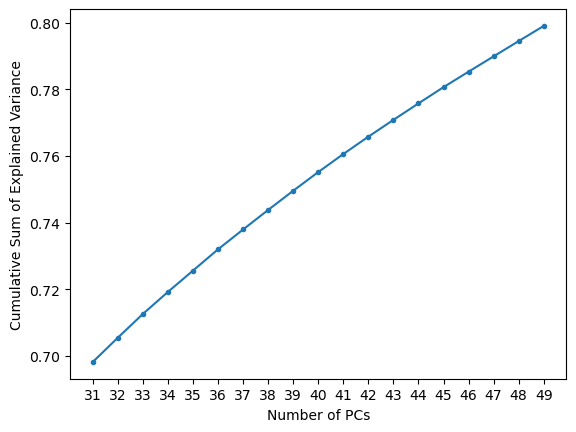

In [18]:
# Plot out the cumulative sum graph, zooming in on the last 20 to see how it's increasing 

plt.figure()
plt.plot(range(31,50), cumulative_sum[30:49], marker='.')  #plotting cumlative sums from 1-51
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Sum of Explained Variance')
plt.xticks(range(31,50,1))
plt.show()

As we can see, the last 20 appear to be almost a perfect straight line, increasing slightly by every additional PC. However, since there isn't an obvious number, we'll go with a percentage instead. In this case we'll go with keeping 90% of the explained variance.

In [19]:
# Instantiate and fit
my_PCA2 = PCA(n_components = 0.9)
my_PCA2.fit(X_train)

# Transform train and test
X_train_PCA2 = my_PCA2.transform(X_train)

In [20]:
#Creating the PCA dataframe 
df_X_train_PCA=pd.DataFrame(X_train_PCA2,index=df_final.index)

In [21]:
from sklearn.neighbors import NearestNeighbors #importing KNN 

In [22]:
#Showing a row of PCA dataframe
df_X_train_PCA[0:1]

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
0,-0.289937,-0.395772,-0.429412,0.016386,-0.207709,0.057949,0.044005,0.314704,-0.138089,-0.21423,...,-0.121063,-0.082344,0.091199,-0.021208,-0.047707,-0.153704,-0.258093,0.121461,0.183936,-0.473881


We can see that the PCA has reduced our columns to ~500 to 84. This is a 1/5 reduction in features. Lets do some quick sanity checks to make sure that nothing has been changed on accident.

In [23]:
#looking at the shape of the dataframe 
df_X_train_PCA.shape[0]

26506

In [24]:
#looking at the shape of the business dataframe 
df_business_final.shape[0]

26506

We see that we have the same number of rows so we can proceed with our KNN.

## Content-Based Recommendations

In this section we'll be exploring the KNN model as a way of recommending similar restaurants. In our case, we'll be using the cosine similarity as a measure of distance. This is defined as the dot product between the two restaurants. This is often the first type of recommendation modeling done. A lot of this section will be done using functions. This is to generalize the recommender systems and make it so that someone could theoretically get one of the indexs of the businesses and easily create their own user and use the system. 

In [25]:
#Instatiating the KNN 
model_knn=NearestNeighbors(metric='cosine', algorithm='brute',n_neighbors=df_business_final.shape[0]-1)

In [26]:
#fitting the knn to the PCA transformed values
model_knn.fit(df_X_train_PCA)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=26505)

After we instantiate our model, we fit the model onto the transformed PCA values. Then we can use a feature of the knn to get the similarity of one index with all the rest of the indexes.   

In [27]:
#Taking a look at how the Array would look like 
model_knn.kneighbors(df_X_train_PCA[0:1])

(array([[0.00000000e+00, 5.84629011e-04, 1.59813057e-02, ...,
         1.35526566e+00, 1.37684172e+00, 1.37799517e+00]]),
 array([[    0, 12558,  7867, ..., 26345, 12365, 20556]]))

As we can see above, splicing out the first index, we can see that it returns two things. The first being the cosine distance from the spliced out restaurant with all its neighbors, in this case the rest of the restaurants. The second being the index of the neighbor. One thing to note is that the first index is 0, the same number of the spliced out restaurant. This is because the restaurant most similar is itself, so the first number should always be the same index as the one you splice out. 

With that being said, lets create a function that will output the similarities based on a single restaurant. 

In [28]:
def recommender_function(index,algo,dataframe_trained,df_names_stored,number_of_rec=10):
    """
    This function will recommend restaurants based on a single inputted restaurant using cosine distance
    
    Input: This function will take in a number of arguments. The first is the index of the restaurant you would like
    to compare to other restaurants. The second argument is the knn model that was fitted on the data. The third 
    argument is the dataframe that we trained the knn model on. The 4th is the dataframe where the names are stored
    on. They should have the same indexs as the trained dataframe. The last is the number of recommendations you want
    printed out. The indecies must be continous before inputting into the function
    
    index: integer index of the restaurant 
    algo: knn model that has been fitted 
    dataframe_trained: the dataframe that the knn was fitted on 
    df_names_stored: A dataframe with a column named 'name' and the same indexes as dataframe_trained.
    number_of_rec: number of recommendations printed out
    
    Output: the output is 2 lists, one where its the list of the recommendations in order of highest similarity to 
    lowest similarity , and the other one is a list of the distances in the same order
    
    
    """
    #instatiating an empty list for recommendations
    recommend_list=[]
    #instatiating an emoty list for distances 
    distance_list=[]
    
    #getting the distances and indices from the knn model 
    distances,indices=algo.kneighbors(dataframe_trained[index:index+1],n_neighbors=dataframe_trained.shape[0])
    
    #Creating a for loop to iterate through the indicies 

    for i in range(0,len(indices.flatten())):
        
        #we flatten out the indicies and select the first index
        index_number=indices.flatten()[i]
        #doing an if statement for the first index
        #the first index should always be the restaurant you put in as that restaurant should be the most similar
        if i ==0:
            #getting the name of the business
            name_business=df_names_stored[df_names_stored.index==index_number]['name']
            
            #stripping the name of quotations 
            name_business=name_business[index_number].strip('\"')
            
            #printing the name 
            print(f'You inputed {name_business} \n')   
            
            #get the distance
            distance_business=distances.flatten()[i]
            
            #print out the distance 
            print({distance_business})
        else:
            
            #find the distance of the business
            distance_business=distances.flatten()[i]
            
            #finding the name using the index
            name_business=df_names_stored[df_names_stored.index==index_number]['name']
            
            #stripping quotation marks 
            name_business=name_business[index_number].strip('\"')
            
            #appending the name and distance 
            recommend_list.append(name_business)
            distance_list.append(distance_business)
    #printing out the top recommendations based on the number_of_rec argument 
    for i in range(0,number_of_rec):
        print(f'#{i} recommendation is {recommend_list[i]} with a distance of {distance_list[i]} \n')
    #returning two lists, with one being the recommendations and the other being distance 
    return recommend_list,distance_list

Above we created a recommender function that takes in an index, among other arguments, to return a list of the recommendations as well as their cosine distance. It also prints out the top results based on how many recommendations you'd like. This can be seen in action below, with index 22.

In [29]:
#checking the restaurant that is index 22 
recommender_function(22,model_knn,df_X_train_PCA,df_business_final)

You inputed Divine Cafe at the Springs Preserve 

{0.0}
#0 recommendation is Milo's Cellar with a distance of 0.05451919789622739 

#1 recommendation is Sunset & Vines with a distance of 0.061151214359081885 

#2 recommendation is RePete's with a distance of 0.07485386518592674 

#3 recommendation is The Phoenix Bar & Lounge with a distance of 0.07695392587462191 

#4 recommendation is She by Morton's with a distance of 0.0792188273608545 

#5 recommendation is Fat Tuesday with a distance of 0.07969797464817452 

#6 recommendation is Sprocket Bar & Restaurant with a distance of 0.08006744283069145 

#7 recommendation is Due & Proper with a distance of 0.08032637224333317 

#8 recommendation is Losers Most Wanted Bar with a distance of 0.08076972748620548 

#9 recommendation is Joey's Tavern with a distance of 0.08335116898974337 



(["Milo's Cellar",
  'Sunset & Vines',
  "RePete's",
  'The Phoenix Bar & Lounge',
  "She by Morton's",
  'Fat Tuesday',
  'Sprocket Bar & Restaurant',
  'Due & Proper',
  'Losers Most Wanted Bar',
  "Joey's Tavern",
  'The Park Restaurant & Bar',
  "Mad Matty's Bar & Grille",
  'The Martini',
  'The Black Door',
  'Beach Bar & Grill',
  'V Bar',
  "Berwick's Urban Lounge",
  'Island Grill',
  'Straight Up Gaming & Martini Lounge',
  'Bistro95Ten & Lounge',
  "DOC Holliday's Saloons",
  'Gordon Biersch Brewery Restaurant',
  'Foundation Room',
  'Killer Shrimp',
  'Dream Cafe & Hookah Bar',
  'Nobhill Tavern by Michael Mina',
  'Beauty & Essex',
  'Cheers Bar & Grill',
  'Morimoto',
  'Harbor House Cafe & Lounge',
  'Pips Cucina & Wine Bar',
  'Stripside Cafe & Bar',
  'Distill - A Local Bar',
  'Luna Lounge',
  'The Bar At Bermuda & St. Rose',
  "Cue-D's Billiards",
  'Encore Players Lounge',
  "PT's Brewing",
  'The Black Sheep',
  'Ocean One Bar and Grille',
  'Very Venice',
  'Crus

We can see that the similarity between Divine Cafe and itself is 0. After we see a considerably higher score with Milo's Cellar. As we didn't input how many recommendations we wanted, it defaulted to 10.

### Testing a user 

However, a recommendation system based solely on a single restaurant wouldn't be very useful. So lets try the same thing but expand onto it and think about using the system to recommend based on multiple restaurants.

In [30]:
#creating a user, the keys are indexs and values are ratings 
user_test={10247:5,132:5}

Here we've created a fake user. This user has rated both the restaurant at index 10247 and 132 as 5 stars. Now lets create a function that does what the last one is doing, but to both restaurants and creates a df as a user. In this way, the columns will be the similarities of every other restaurant to the restaurants that the user has been too.

In [31]:
def user_creation(user,algo,df_trained,df_name_stored):
    
    """
    Input: The first argument is a user, that is in the form of a dictionary. The second is the knn model that should 
    be fitted on a dataframe. The next is the dataframe that the KNN was trained on. The last is a dataframe 
    where the names are stored.
    Types:
    user:dictionary 
    algo:KNN model
    df_trained: pandas dataframe 
    df_name_stored: pandas dataframe 
    
    output: a pandas dataframe that will be the similarity between the input restaurants and the rest of the 
    restaurants. Values closer to 0 between restaurants indicate higher similarity 
    
    
    """
    
    #creating the user_df 
    user_df=df_name_stored[['name','state']]
    index_list=[]
    #for loop over the indexes in the user input
    for index in user:
        #getting the distances and indices from the knn 
        distances,indices=algo.kneighbors(df_trained[index:index+1],n_neighbors=df_trained.shape[0])
        
        #getting the names of the businesses 
        name_business=df_name_stored[df_name_stored.index==index]['name']
        
        #stripping the name of the businesses 
        name_business=name_business[index].strip('\"')
        
        #Creating column that are named by the name of the business + similarity with values based on similarity of
        #each business with the input business 
        similarity_df = pd.DataFrame(distances.flatten(),index=indices.flatten(),columns=[name_business+' Similarity'])
                
        #concatting the column into the user dataframe
        user_df=pd.concat((user_df,similarity_df),axis=1)
        index_list.append(index)
        
    user_df.drop(index_list,inplace=True)
        
        
        #returning the user df
    return user_df

In [32]:
#Assigning the output of user_creation to a variable new_user
new_user=user_creation(user_test,model_knn,df_X_train_PCA,df_business_final)

In [33]:
#looking at the first 5 rows
new_user.head()

,name,state,Mildred's Temple Kitchen Similarity,Bayside Buffet at Mandalay Bay Similarity
0,"""T & T Bakery and Cafe""",ON,0.998816,1.106466
1,"""Alize Catering""",ON,1.001158,1.065771
2,"""Maxim Bakery & Restaurant""",ON,1.035650,1.109898
3,"""Starbucks""",ON,0.999892,1.170051
4,"""Sportster's""",ON,1.060273,1.121115


Looking at the above, we can see that our function has created our "user". His dataframe columns are the name and state from previous dataframes, but now we have the similarities to the two restaurants they've rated. One thing to note, is that with dot product and cosine distance, a higher distance is further away and lower distance is closer. Another thing to note is that in this case we've decided to keep state as a column to use it as a filter. Any of our other columns could have been saved as well to use as a filter. For example, we had tags like chinese or italian, and those very well could have been kept and used as a filter. This notebook will primarily use state as an additional filter since the premise is personal traveling food recommendations, however any other tag would function the same way. 

### Filtering by State

Now lets filter our dataframe by state. In this case, this user only wants recommendations from ON.

In [34]:
#Assigning the string ON to a variable 
state_variable='ON'

In [35]:
new_user.isna().sum()

name                                         0
state                                        0
Mildred's Temple Kitchen Similarity          0
Bayside Buffet at Mandalay Bay Similarity    0
dtype: int64

In [36]:
new_user

,name,state,Mildred's Temple Kitchen Similarity,Bayside Buffet at Mandalay Bay Similarity
0,"""T & T Bakery and Cafe""",ON,0.998816,1.106466
1,"""Alize Catering""",ON,1.001158,1.065771
2,"""Maxim Bakery & Restaurant""",ON,1.035650,1.109898
3,"""Starbucks""",ON,0.999892,1.170051
4,"""Sportster's""",ON,1.060273,1.121115
...,...,...,...,...
26501,"""Chaska""",ON,0.987621,1.111930
26502,"""Urban House Cafe""",ON,0.794175,1.103703
26503,"""Sweet Serendipity Bake Shop""",ON,1.002040,1.132001
26504,"""Starbucks""",NV,1.155687,0.826664


In [37]:
#Filtering state column by state variable 
new_user[new_user['state'].str.contains(state_variable)]

,name,state,Mildred's Temple Kitchen Similarity,Bayside Buffet at Mandalay Bay Similarity
0,"""T & T Bakery and Cafe""",ON,0.998816,1.106466
1,"""Alize Catering""",ON,1.001158,1.065771
2,"""Maxim Bakery & Restaurant""",ON,1.035650,1.109898
3,"""Starbucks""",ON,0.999892,1.170051
4,"""Sportster's""",ON,1.060273,1.121115
...,...,...,...,...
26500,"""Heritage Fish & Chips""",ON,1.061533,1.185176
26501,"""Chaska""",ON,0.987621,1.111930
26502,"""Urban House Cafe""",ON,0.794175,1.103703
26503,"""Sweet Serendipity Bake Shop""",ON,1.002040,1.132001


This can be seen that despite Bayside Buffet being a restaurant from Las Vegas, its still possible to compare it to restaurants from the GTA and vice versa. You can just filter by whichever state you want recommendations for and filter for the best ones. Now that we've done that, we can drop the non-numeric columns, to allow for some scaling based on the stars that were given to each business.

In [38]:
#Dropping the name and state column
new_user=new_user.drop(columns=['name','state'])

### Scaling

To start, we'll be swapping the way that the businesses are evaluated. Previously, a number closer to 0 was seen as more similar and a number further away was seen as less similar. However this created an issue where scaling it based on rating was less intuitive. As a result, we'll be swapping the max and min and everything in between. This will allow for scaling by multiplying each column by the rating that the user gave that restaurant. This means that a number previously having a score of 0 will now have the max score in that column, and vice versa. 

In [39]:
#starting a for loop that will flip the values. This means that the minimum will become the max and vise versa. 
for i in range(0,len(new_user.columns)):
    #Finding the maximum value 
    maximum=new_user[new_user.columns[i]].max()
    #flipping the values 
    new_user[new_user.columns[i]]=maximum-new_user[new_user.columns[i]]

In [40]:
#sorting the values 
new_user[new_user.columns[0]].sort_values(ascending=False)

5101     1.052741
13355    1.026262
6492     1.013946
21867    0.948081
2870     0.941280
           ...   
8241     0.004260
17605    0.004015
15419    0.001536
25811    0.000786
4604     0.000000
Name: Mildred's Temple Kitchen Similarity, Length: 26504, dtype: float64

In [41]:
#displaying user_test 
user_test

{10247: 5, 132: 5}

We can see that looking at the Mildred's Temple Kitchen Similarity, that the highest value now is mildred's temple kitchen. So we can proceed. 

Now we need to create a list of the review scores. We can do this by iterating over the dictionary and appending the scores to a list. We'll then loop over the list and multiply the column by its corresponding review score.

In [42]:
#Creating an empty list
review_list=[]
#for loop over the indexs 
for index in user_test:
    #getting the review_stars and appending it to the list 
    review_list.append(user_test[index])
#Printing the review_list
print(review_list)
    

[5, 5]


In [43]:
#making sure that the length of the review list is the same as the column number 
len(new_user.columns)==len(review_list)

True

We also do a quick sanity check to see that the length of the number of columns is the same as the length of the review_list. 

In [44]:
#creating a for loop over review_list
for i in range(0,len(review_list)):
    #scaling the columns based on the rating
    new_user[new_user.columns[i]]=review_list[i]*new_user[new_user.columns[i]]

After we scale the values, we'll sum across the row. This will sum all the similarities for a particular business across all the businesses the user has been to before. We'll then take the largest numbers and those will be the recommended businesses.  

In [45]:
#summing over the rows for the businesses 
new_user.sum(axis=1).sort_values(ascending=False).head(10)

710      7.839366
3414     7.346715
13628    7.317764
20553    7.265784
4504     7.265623
14322    7.122514
2870     7.090590
3298     7.081738
1032     7.079144
20272    7.043303
dtype: float64

After we've scaled, we can see that the values have increase a lot. This gives the user more control, as restaurants they rate higher will be weighed higher. So lets create a function to do all the scaling we've just done.

### Create a Function

In [46]:
#printing the user_test dictionary 
user_test

{10247: 5, 132: 5}

In [47]:
def scaling_by_rating(user_dict,unscaled_df,num_recommendations=10,state='all'):
    """
    This function aims to scale the column similarity based on the rating given to the restaurant 
    
    Input: The first argument is a dictionary made of the restaurants they've gone to and the ratings they've given
    them. The second argument is the unscaled dataframe made from user_creation. the next one is how many 
    recommendations to print out, and the last one is the state that they want to include
    
    type:
    user_dict: dictionary 
    unscaled_df: pandas dataframe
    num_recommendations: int
    state= string
    
    output: a pandas dataframe with rows size given by num_recommendations and potentially sorted by state 
    
    
    """
    #creating a copy of the unscaled df
    copy_df=unscaled_df.copy()
    
    #Sorting by Ontario or Nevada
    if state == 'ON' or state == 'NV':
        unscaled_df=unscaled_df[unscaled_df['state'].str.contains(state)]
    
    #Dropping unnecessary columns
    unscaled_df=unscaled_df.drop(columns=['name','state'])
    
    #making min -> max ranking change to max->min ranking 
    for i in range(0,len(unscaled_df.columns)):
        #getting the maximum 
        maximum=unscaled_df[unscaled_df.columns[i]].max()
        #swapping the max and min scale 
        unscaled_df[unscaled_df.columns[i]]=maximum-unscaled_df[unscaled_df.columns[i]]
        
    #creating a empty list 
    review_list=[]
    
    #Getting the review score
    for index in user_dict:
        review_list.append(user_dict[index])
        
        
    #asserting that the lengths are the same 
    if len(unscaled_df.columns)==len(review_list):
        #iterating over the review_list 
        for i in range(0,len(review_list)):
            #scaling the columns based on the review score 
            unscaled_df[unscaled_df.columns[i]]=review_list[i]*unscaled_df[unscaled_df.columns[i]]
    #if it is not equal then it will print the lengths of each
    else: print(len(review_list),len(unscaled_df.columns)) 
    
    #getting the top number of recommendations based on input
    top_x=unscaled_df.sum(axis=1).sort_values(ascending=False).head(num_recommendations)
    
    #merging the dataframe to get the names
    result_df=pd.merge(copy_df['name'],pd.DataFrame(top_x,columns=['Result']),left_index=True,right_index=True)
    
    #sorting by Result 
    result_df=result_df.sort_values(by='Result',ascending=False)
    
    #returning a dataframe 
    return result_df

Above we created a function that will spit out a dataframe of the top recommendations. Now lets try it on a new user. So we'll first have to create a user using our user_creation method. Then we will use this new user_df and input it into our new function. 

In [48]:
#Creating a user dataframe 
new_user_df=user_creation(user_test,model_knn,df_X_train_PCA,df_business_final)

In [49]:
#Creating the scaled dataframe 
test_series=scaling_by_rating(user_test,new_user_df)

In [50]:
#showing the scaled results 
test_series

,name,Result
710,"""Cravings Buffet""",7.839366
3414,"""The Buffet at Luxor""",7.346715
13628,"""MGM Grand Buffet""",7.317764
20553,"""Spice Market Buffet""",7.265784
4504,"""Carnival World Buffet""",7.265623
14322,"""The Buffet at Bellagio""",7.122514
2870,"""360 Restaurant""",7.090590
3298,"""Serendipity 3""",7.081738
1032,"""The Coffee Shop""",7.079144
20272,"""Hash House A Go Go""",7.043303


We can see that the method seems to be working. We'll be sure to visit Cravings Buffet!

### Model Evaluation 

Recommender systems are notoriously difficult to evaluate. Unless you're getting active data on how your recommendations are doing, it is very hard to evaluate if the recommendations are good recommendations or bad recommendations. Unfortunately, the project doesn't have millions of users to test recommendations on. So the alternative is to test on data we already have. What we'll be doing is splitting up the restaurants that a user has reviewed into a train and a test. The model will make predictions based on a the train, and we'll see how many of the test we capture. 

In [51]:
from sklearn.model_selection import train_test_split #importing train_test_split

Here we're implementing a train_test_split. The process below will go as follows:

- We'll create our surprise dataframe,
- Grab a user from our dataframe 
- We'll grab all the reviews from this user
- Perform a train test split on this user. 
- 'train' our recommender system based on the user
- 'test' on our test set
- calculate accuracy and precision for the single test.

In [52]:
#Creating the suprise dataframe 
df_reviews_suprise=df_reviews_merged[['user_id','business_id','Review_star']] 

In [53]:
#assigning a user_id to a variable 
user_id_test='PBV_oQCoABX958-zjiLGwQ'

We've selected our user and created our dataframe.

In [54]:
#Creating a user by using a boolean condition
df_user_test=df_reviews_suprise[df_reviews_suprise['user_id']==user_id_test]

In [55]:
#Splitting the users reviews in train and test 
X_train,X_test=train_test_split(df_user_test,test_size=0.5,random_state=42)

In [56]:
#getting the number of rows in X_train
X_train.shape[0]

38

In [57]:
#getting the number of rows in X_test
X_test.shape[0]

39

After performing the train-test split, we see we have 38 restaurants to train on and 39 to try to hit.

In [58]:
#dropping the user id from train data 
X_train.drop(columns='user_id',inplace=True)

/var/folders/wd/_ly9th917n5cfwyp82k_61wr0000gn/T/ipykernel_26462/3333616891.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(columns='user_id',inplace=True)


In [59]:
X_train.head()

,business_id,Review_star
53111,XiMvHK4Nq0xPa1GOtdKzdA,4
507755,ax4ztJvW28xgGvI0OPqGcQ,3
901881,syRPwPqdV6h3eenuV1d6rg,3
197842,_H275sBtkJX0yJ5Br_vM0A,3
1338472,HQpMwOOrGND3GaRqMNV9ig,3


We're now at the stage where we have the businesses that the user has gone to and the stars they've given that particular restaurant. Now the steps will be similar to what we've done before. But first, we need to merge the businesses with our `df_business_final` to get the correct indexs for the businesses.

In [60]:
#Creating a series that is just buisness_id
df_business_series=df_business_final['business_id']

In [61]:
#Resetting the index in the series 
df_business_indexs=df_business_series.reset_index()

In [62]:
#merge the trained data with the business id to get business ids as well as indexs 
user_df_indexs=pd.merge(df_business_indexs,X_train,how='inner')

We've now gotten the indexes, so we'll now need to convert our series to a dictionary in order to be able to use it in our user_creation function

In [63]:
#dropping the business Ids 
user_df_indexs.drop(columns='business_id',inplace=True)

In [64]:
#setting the index 
user_df_indexs=user_df_indexs.set_index('index')

Here we set the user to have the index we need from `df_business_final`

In [65]:
#Creating a dictionary with indexs and star reviews 
user_train_dict=pd.Series.to_dict(user_df_indexs['Review_star'])

In [66]:
#Using the user creation method to create the unscaled dataframe
unscaled_similarity_df=user_creation(user_train_dict,model_knn,df_X_train_PCA,df_business_final)

In [67]:
#creating the top_x_restaurants 
top_x_restaurants=scaling_by_rating(user_train_dict,unscaled_similarity_df,50)

After we create our dictionary, we pass the dictionary through our other two functions and get the top restaurants. 

In [68]:
#top 5 rows 
top_x_restaurants.head()

,name,Result
16339,"""Fishman Lobster Clubhouse Restaurant""",72.230932
25175,"""Maple Yip Seafood Restaurant""",71.828876
14994,"""Magic Noodle""",71.195417
2738,"""Congee Queen""",71.027921
19272,"""Congee Queen""",70.899994


Now we'll need to gather the test indexes.

### Test Indexes

In [69]:
#Dropping the user_id
X_test.drop(columns='user_id',inplace=True)
#merging it with business ID to get indexs
user_df_indexs_test=pd.merge(df_business_indexs,X_test,how='inner')

/var/folders/wd/_ly9th917n5cfwyp82k_61wr0000gn/T/ipykernel_26462/2162332878.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(columns='user_id',inplace=True)


Here we're doing a similar step of merging the test indices with the business dataframe to get the correct business indexes. The biggest difference being that we don't need to run it through our functions this time.

In [70]:
#Creating a set from top_x_restaurants indicies
set_1=set(top_x_restaurants.index)

Now we turn our recommended restaurants indexes into a set and our test indexes into a set and use the intersection method to see where they share the same values.

In [71]:
#getting the indexs from the test dataframe 
test_indexs=user_df_indexs_test.set_index('index')

In [72]:
#Second set
set_2=set(test_indexs.index)

In [73]:
#intersection between the two sets 
set_1.intersection(set_2)

{25175}

We can see we got one hit here. This is the restaurant that we correctly recommended to the user. Now we need to find a way to generate users and find their intersection amount.

### Creating a function to get users

Here we'll be creating a function that will give us a random sample of users with a certain number of minimum reviews. These users will be used to evaluate our model. 

In [74]:
def user_sample(number_of_samples,dataframe,minimum_reviews,random_state_num=None):
    """
    Creating a sample of users 
    
    input: number_of_samples is an argument that dictates how many samples to take, the second argument is the 
    dataframe that is used that has user_id and business_id. The third argument dictates,
    the minimum number of reviews a user must have to be included in the sample.
    type:
    number_of_samples: integer
    dataframe: pandas dataframe
    minimum_reviews: integer
    random_state_num:integer
    
    output is a list of users 
    
    """
    
    #grouping by user_id and counting the number of businesses the user has gone too
    user_review_count=dataframe[['user_id','business_id']].groupby('user_id').count()
    
    #Applying a boolean to the dataframe to filter for only users that have at least the minimum reviews 
    user_review_count=user_review_count[user_review_count['business_id']>=minimum_reviews]
    
    #Creating a list by sampling from the users that have higher than the minimum number of reivews 
    user_x=user_review_count.sample(number_of_samples,random_state=random_state_num)
    
    
    return user_x

This function spits out a list of 100 random users that meet the minimum review condition

In [75]:
#getting the first index 
user_sample(100,df_reviews_merged,15,20).index[0]

'pqeKwWu7n2hJuvh1I7DMZA'

Now that we have a way to generate users, we should also create a function that finds the intersection for us.

In [76]:
def user_intersecton(user_id,recommend_number,algo,df_trained,df_named_business,df_review_id,random_num=None):
    """
    This function will check the intersection between the recommendations based on the train set and the test set.
    
    input: 
    user_id: Takes in a single user id, the type would is a str 
    recommend_number: takes in an integer 
    algo: takes in a fitted knn model
    df_trained: takes in a pandas dataframe that the knn was trained on 
    df_named_business: takes in a dataframe with the names of the businesses. indexs should match df_trained
    df_review_id: takes in a dataframe with the review indexs 
    random_num: gives the random state for the train-test split
    
    Output: Outputs a set of the intersections, an accuracy and a precision
    
    """
    #Creating the df of a single test user 
    df_user_test=df_review_id[df_review_id['user_id']==user_id]
    
    #Creating a train test split for the user
    X_train,X_test=train_test_split(df_user_test,test_size=0.5,random_state=random_num)
    
    #dropping user id
    X_train.drop(columns='user_id',inplace=True)
    
    #Creating a business_series 
    df_business_series=df_named_business['business_id']
    
    #Resetting the index
    df_business_indexs=df_business_series.reset_index()
    
    #Inner merge to obtain the business indicies
    user_df_indexs=pd.merge(df_business_indexs,X_train,how='inner')
    
    #Dropping business id
    user_df_indexs.drop(columns='business_id',inplace=True)
    
    #setting the index to the reset index 
    user_df_indexs=user_df_indexs.set_index('index')
    
    #creating a dictionary from the remaining users 
    user_train_dict=pd.Series.to_dict(user_df_indexs['Review_star'])
    
    #Creating the user dataframe 
    unscaled_similarity_df=user_creation(user_train_dict,algo,df_trained,df_named_business)
    
    #scaling the user dataframe 
    top_x_restaurants=scaling_by_rating(user_train_dict,unscaled_similarity_df,recommend_number)
    
    #Creating a set for the indexes 
    set_1=set(top_x_restaurants.index)
    
    #Dropping columns from test dataset
    X_test.drop(columns='user_id',inplace=True)
    
    #Merging with the business indexes 
    user_df_indexs_test=pd.merge(df_business_indexs,X_test,how='inner')

    #Getting the indexes for the test dataframe 
    test_indexs=user_df_indexs_test.set_index('index')
    
    #Creating Second set
    set_2=set(test_indexs.index)
    
    #testing to see where they overlap
    intersection=set_1.intersection(set_2)
    
    #deciding accuracy rating 
    
    accuracy=len(intersection)/recommend_number
    
    precision=len(intersection)/len(set_2)
    return intersection, accuracy, precision

Above is a function that will take in a user, along with some other arguments, and spit out it's intersection as well as it's accuracy and precision for that user. The process is analogous to the process shown above with a single user. Accuracy is defined as how many of our recommendations were part of the test set, and precision is defined as how many of the test set did we manage to get. The process for evaluating the model will be to generate random users and test the precision and accuracy.  

In [77]:
#Getting one user from the sample
one_user_id=user_sample(100,df_reviews_merged,15,20).index[99]

In [78]:
#Displaying the user id
one_user_id

'HOwaLgwPKy0caLrwkPr80A'

In [79]:
#finding the user intersection 
user_intersecton(one_user_id,50,model_knn,X_train_PCA2,df_business_final,df_reviews_merged,42)[1:]

/var/folders/wd/_ly9th917n5cfwyp82k_61wr0000gn/T/ipykernel_26462/2825760146.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(columns='user_id',inplace=True)
/var/folders/wd/_ly9th917n5cfwyp82k_61wr0000gn/T/ipykernel_26462/2825760146.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(columns='user_id',inplace=True)


(0.0, 0.0)

Above we saw an example of finding a single user, and finding its precision and accuracy. IN this case, we managed to hit none so our precision and accuracy was 0. We can actually iterate over a for loop to go over all users in the sample. This is shown below.

In [80]:
#Creating a for loop to iterate through all the users in the sample
import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter for warnings 

#Creating empty list for accuracy 
accuracy_list=[]
#creating empty list for precision 
precision_list=[]
#Getting a user sample with random state 20
user_sampled=user_sample(100,df_reviews_merged,15,20)
#for loop over the 100 users 
for num in range(0,100):
    print(f"Working on n={round(num,1)}...", end="\r") #PROTIP for progress bars...
    
    #getting the intersection between the two 
    output=user_intersecton(user_sampled.index[num],50,model_knn,X_train_PCA2,df_business_final,df_reviews_merged)
    #getting the accuracy and appending it to a list
    accuracy_list.append(output[1])
    #getting the precision and appending it to a list 
    precision_list.append(output[2])

We can then get the mean of the lists. Note that these are not weighted means so every user is treated equally. 

In [81]:
#getting the mean over the accuracy list
np.mean(accuracy_list)

0.0174

In [82]:
#getting the mean over the precision list 
np.mean(precision_list)

0.050897523170252576

Our accuracy and precision is rather low which is too be expected. This method while is a way of evaluating recommender systems, is not necessarily that people would not enjoy our recommendations, but rather that our system is bad at predicting restaurants users have already been too. Now lets iterate over different number of user samples to see if this will affect our precision and accuracy.

In [83]:
#checking that 200 samples are in 200
user_sample(200,df_reviews_suprise,15).shape[0]

200

In [84]:
#Creating empty list for accuracy means
accuracy_means=[]
#creating empty list for precision means
precision_means=[]

#Creating a range to iterate over
outside_range=np.arange(20,150,40)

#Nested for loop to get the accuracy for multiple sample sizes 
for outside_num in outside_range:
    import warnings
    warnings.filterwarnings('ignore') # setting ignore as a parameter
    
    #empty list for accuracy
    accuracy_list=[]
    #creating empty list for precision 
    precision_list=[]
    #Creating the user sample 
    user_sampled=user_sample(outside_num,df_reviews_merged,15,random_state_num=None)
    for num in range(0,outside_num):
        print(f"Working on n={round(num,1)}...", end="\r") #PROTIP for progress bars...
        #getting the intersection
        output=user_intersecton(user_sampled.index[num],50,model_knn,X_train_PCA2,df_business_final,df_reviews_merged)
        #appending the accuracy
        accuracy_list.append(output[1])
        #appending the precision 
        precision_list.append(output[2])
    #appending the mean of the current user sample
    accuracy_means.append(np.mean(accuracy_list))
    #appending the mean of the current precision sample
    precision_means.append(np.mean(precision_list))
print('Done')
    

Doneing on n=139...


We will be iterating in batches as otherwise the kernal will crash.

In [85]:
outside_range=np.arange(150,230,40)

#Nested for loop to get the accuracy for multiple sample sizes 
for outside_num in outside_range:
    import warnings
    warnings.filterwarnings('ignore') # setting ignore as a parameter
    
    #empty list for accuracy
    accuracy_list=[]
    #creating empty list for precision 
    precision_list=[]
    #Creating the user sample 
    user_sampled=user_sample(outside_num,df_reviews_merged,15,random_state_num=None)
    #For loop iterating over the sample
    for num in range(0,outside_num):
        print(f"Working on n={round(num,1)}...", end="\r") #PROTIP for progress bars...
        #getting the intersection 
        output=user_intersecton(user_sampled.index[num],50,model_knn,X_train_PCA2,df_business_final,df_reviews_merged)
        #appending the accuracy to the list
        accuracy_list.append(output[1])
        #appending the precision to the list 
        precision_list.append(output[2])
    #appending the accuracy mean of the current sample
    accuracy_means.append(np.mean(accuracy_list))
    #appending the precision mean of the current sample
    precision_means.append(np.mean(precision_list))
print('Done')
    

Doneing on n=189...


Now that we've iterated over them and found the mean precisions for different user_samples, lets plot the results to see if we see any trends.

In [86]:
#Creating our X_range for the graph
X_range=(20,60,100,140,150,190)

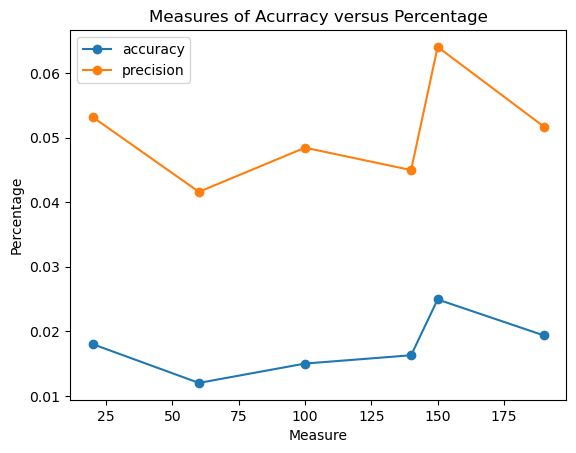

In [87]:
plt.plot(X_range,accuracy_means,label='accuracy',marker='o') #plotting the accuracy
plt.plot(X_range,precision_means,label='precision',marker='o') #plotting the precision 
plt.ylabel('Percentage')
plt.xlabel('Measure')
plt.title('Measures of Acurracy versus Percentage')
plt.legend() #showing the legend 
plt.show()

Looking at the graph we don't see any individual trends. We do see that precision tends to be higher than accuracy in this method. This makes sense as, as you predict more it's more likely to hit the ones that the users have been too. This also might be a result of most users not having a large amount of reviews. While we set our minimum to 15 reviews in this case. We are still observing low precision and accuracy however. Lets look at if changing the number of recommendations will affect the precision and accuracy.

In [89]:
#Creating empty list for accuracy means
accuracy_means=[]
#creating empty list for precision means
precision_means=[]

#Creating a range to iterate over
outside_range=np.arange(20,101,20)

#Nested for loop to get the accuracy for multiple sample sizes 
for outside_num in outside_range:
    import warnings
    warnings.filterwarnings('ignore') # setting ignore as a parameter
    
    #empty list for accuracy
    accuracy_list=[]
    #creating empty list for precision 
    precision_list=[]
    #Creating the user sample 
    user_sampled=user_sample(100,df_reviews_merged,outside_num,random_state_num=None)
    for num in range(0,100):
        print(f"Working on n={round(num,1)}...", end="\r") #PROTIP for progress bars...
        #getting the intersection
        output=user_intersecton(user_sampled.index[num],50,model_knn,X_train_PCA2,df_business_final,df_reviews_merged)
        #appending the accuracy
        accuracy_list.append(output[1])
        #appending the precision 
        precision_list.append(output[2])
    #appending the mean of the current user sample
    accuracy_means.append(np.mean(accuracy_list))
    #appending the mean of the current precision sample
    precision_means.append(np.mean(precision_list))
print('Done')

Doneing on n=99...


Here we're doing the same nested for loop to create our accuracy and precision means 

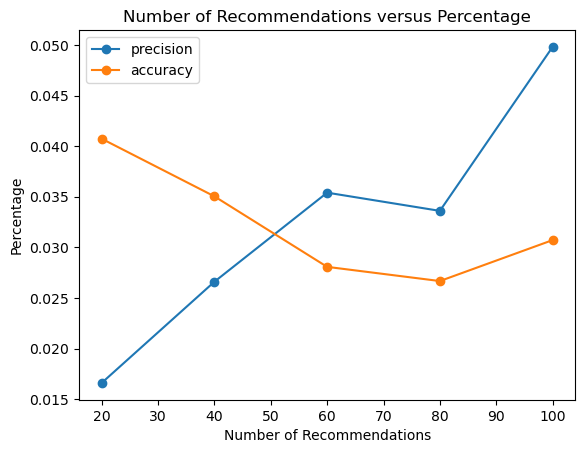

In [94]:
plt.plot(outside_range,accuracy_means,label='precision',marker='o') #plotting the precision
plt.plot(outside_range,precision_means,label='accuracy',marker='o') #plotting the accuracy 
plt.ylabel('Percentage')
plt.xlabel('Number of Recommendations')
plt.title('Number of Recommendations versus Percentage')
plt.legend() #showing the legend 
plt.show()

We actually see a trend here. As we are increasing the number of recommendations, our precision appears to be increasing. As well our accuracy appears to be lowering. Regardless, the KNN model is not performing well in our evaluation method. However, this is likely due a number of factors. The first being that the features we have aren't doing their job of creating distinct groups of restaurants that people would go to. The second being that simply most of the users aren't going to a lot of restaurants/leaving a review to most restaurants. I know personally I only usually leave reviews if theres some monetary benefit. The third problem is potentially, people don't tend to go to one type of restaurant. There are so many different cuisines that maybe the features are only recommending one type of restaurant. The last potential problem that I'll mention is the potential that the restaurants selected should have been more curated. Selecting only one specific region might improve accuracy and precision as people tend to go out to the restaurants close to them.

### Cold Start

The last thing we'll address in this notebook is the idea of a cold start. The cold start problem is something all recommender systems will face. It's essentially what do you do with a new user. One way of addressing the cold start problem is to ask for a few restaurants when a user signs up and use that to recommend, another way is to use popularity. In our case we'll use popularity in combination with a high avg stars.

In [95]:
#looking for businesses with more than 200 reviews 
df_greater_200=df_business_final[df_business_final['review_count']>200]

In [96]:
#Sorting by highest avg stars
df_greater_200[df_greater_200['state'].str.contains('ON')].sort_values('avg_stars',ascending=False).head()

,copy_index,business_id,name,state,avg_stars,review_count,BusinessParking_valet,WheelchairAccessible,km_distance_from_center,active,...,n^took,n^try,n^ve,n^vegas,n^wait,n^want,n^wanted,n^wasn,n^way,n^went
19224,23648,Yl2TN9c23ZGLUBSD9ks5Uw,"""Byblos""",ON,4.5,556,0,0,0.980314,0,...,7.0,6.0,8.0,0.0,6.0,16.0,5.0,13.0,10.0,9.0
14469,17792,zfQ855VX3SMA_54oVSN5Cw,"""Fresco's Fish & Chips""",ON,4.5,280,0,0,1.676522,0,...,1.0,7.0,7.0,0.0,2.0,2.0,0.0,10.0,5.0,9.0
9903,12159,SGP1jf6k7spXkgwBlhiUVw,"""Kekou Gelato House""",ON,4.5,363,0,0,0.978345,0,...,0.0,4.0,3.0,0.0,0.0,0.0,1.0,2.0,2.0,4.0
9910,12170,c35qzLN6ItDpVIoj2uQW4Q,"""Ravi Soups""",ON,4.5,309,0,0,1.185929,0,...,7.0,15.0,8.0,0.0,2.0,8.0,3.0,16.0,10.0,3.0
18997,23364,lDpVyjENOz_qbxbRoyBi8w,"""Black Camel""",ON,4.5,283,0,0,2.617245,0,...,0.0,11.0,6.0,0.0,1.0,2.0,0.0,12.0,7.0,6.0


Based on this, our top 5 restaurants we would recommend to a new user in Toronto are these 5. All great restaurants! 

## Conclusion to This Notebook

In this notebook, we started to explore the reviews dataframe. We finalized the `df_business_final` dataframe, as well as looked into applying PCA and scaling. We also built a content-based recommender system using KNN. We built functions to simulate how to deal with a new_user and streamline recommendations. We built a method of evaluating our system by generating random users, and tracking our precision and accuracy over these users. We lastly, discussed solutions to the cold start problem. In the next notebook, we'll be going over the other common method to recommender systems, which is collaborative filtering.